In [1]:
# hydrological packages

import hydroeval as he


# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# system packages
from progressbar import ProgressBar
from datetime import datetime, date
import pickle
import warnings
warnings.filterwarnings("ignore")
import platform
import time

# data analysi packages
from scipy import optimize
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


ModuleNotFoundError: No module named 'hydroeval'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
if platform.system() == 'Windows':
    onedrive_path = 'E:/OneDrive/OneDrive - The University of Alabama/10.material/01.data/usgs_data/'
    box_path = 'C:/Users/snaserneisary/Box/NWM-ML/'

elif platform.system() == 'Darwin':
    onedrive_path = '/Users/savalan/Library/CloudStorage/OneDrive-TheUniversityofAlabama/02.projects/03.ciroh/04.data/'
    box_path = '/Users/savalan/Library/CloudStorage/Box-Box/NWM-ML/Data/NWM/ut/'
    
elif platform.system() == 'Linux':
    path_01 = '/home/ec2-user/SageMaker/01.projects/01.ciroh_p8/NWM-ML/savalan/'

In [4]:


def Model_Evaluation_Plots(DF, predictions):

# Subplots.
    fig, ax = plt.subplots(1,1, figsize=(8, 7))
    fig.patch.set_facecolor('white')

    #set min/max for y-axis of the predictions/observations
    ymin = min(DF['flow_cfs'])*1.1
    ymax = max(DF['flow_cfs'])*1.1

    #add color options
    colors = ['blue', 'orange', 'red','green']


    # Add predictions to plot
    for pred in np.arange(0, len(predictions),1):
        ax.scatter(DF['flow_cfs'], DF[predictions[pred]],
                   c=colors[pred], alpha=0.35, label=predictions[pred])

     # Add some parameters.
    ax.set_title('Streamflow Predictions', fontsize=16)
    ax.set_xlabel('Observations (cfs)', fontsize=14)
    ax.set_ylabel('Predictions (cfs)', fontsize=14,)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(ymin, ymax)
    ax.legend(fontsize=14, loc='upper right')

    #Add a 1:1 prediction:observation plot
    ax.plot((0,ymax),(0,ymax), linestyle = '--', color  = 'red')

    plt.show()


#Define some key model performance metics: RMSE, PBias, MAE, MAPE
def RMSE(DF, predictions):
    for pred in np.arange(0, len(predictions),1):
        rmse = mean_squared_error(DF['flow_cfs'], DF[predictions[pred]], squared=False)
        print('RMSE for ', predictions[pred], ' is ', rmse, ' cfs')

def MAPE(DF, predictions):
    for pred in np.arange(0, len(predictions),1):
        mape = round(mean_absolute_percentage_error(DF['flow_cfs'], DF[predictions[pred]])*100, 2)
        print('Mean Absolute Percentage Error for ', predictions[pred], ' is ', mape, '%')

def PBias(DF, predictions):
    for pred in np.arange(0, len(predictions),1):
        pbias = he.evaluator(he.pbias,  DF[predictions[pred]], DF['flow_cfs'])
        pbias = round(pbias[0],2)
        print('Percentage Bias for ', predictions[pred], ' is ', pbias, '%')

def KGE(DF, predictions):
    for pred in np.arange(0, len(predictions),1):
        kge, r, alpha, beta = he.evaluator(he.kge,  DF[predictions[pred]], DF['flow_cfs'])
        kge = round(kge[0],2)
        print('Kling-Glutz Efficiency for ', predictions[pred], ' is ', kge)


In [5]:
raw_training_data = pd.read_csv(path_01 + '03.output/raw_training_data.csv')
raw_training_data.pop('Unnamed: 0')
raw_training_data['station_id'] = raw_training_data['station_id'].astype('str')
raw_training_data

,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,...,datetime,flow_cfs,s1,s2,temperature_F,precipitation_in,storage,swe,NWM_flow,DOY
0,10011500,40.965225,-110.853508,174.00,9720.0,67.70,1.2,0.120,2.94,27.2,...,2012-03-13,45.356945,0.515038,0.857167,35.096,0.00000,0.0,7.70,60.0,73
1,10011500,40.965225,-110.853508,174.00,9720.0,67.70,1.2,0.120,2.94,27.2,...,2012-03-14,49.750000,0.515038,0.857167,35.258,0.00000,0.0,7.45,62.0,74
2,10011500,40.965225,-110.853508,174.00,9720.0,67.70,1.2,0.120,2.94,27.2,...,2012-03-15,52.483334,0.515038,0.857167,36.860,0.00000,0.0,7.35,65.0,75
3,10011500,40.965225,-110.853508,174.00,9720.0,67.70,1.2,0.120,2.94,27.2,...,2012-03-16,60.296875,0.515038,0.857167,38.120,0.00000,0.0,7.25,63.0,76
4,10011500,40.965225,-110.853508,174.00,9720.0,67.70,1.2,0.120,2.94,27.2,...,2012-03-17,68.876045,0.515038,0.857167,38.102,0.04698,0.0,6.85,65.0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60039,10172952,41.858530,-113.327219,8.57,8190.0,6.01,0.0,0.021,40.20,57.5,...,2020-02-25,1.530000,0.000000,1.000000,27.644,0.00000,0.0,0.00,1.0,56
60040,10172952,41.858530,-113.327219,8.57,8190.0,6.01,0.0,0.021,40.20,57.5,...,2020-02-26,1.530000,0.000000,1.000000,29.876,0.00000,0.0,0.00,1.0,57
60041,10172952,41.858530,-113.327219,8.57,8190.0,6.01,0.0,0.021,40.20,57.5,...,2020-02-27,1.545208,0.000000,1.000000,35.438,0.00000,0.0,0.00,1.0,58
60042,10172952,41.858530,-113.327219,8.57,8190.0,6.01,0.0,0.021,40.20,57.5,...,2020-02-28,1.717708,0.000000,1.000000,38.498,0.00000,0.0,0.00,1.0,59


In [6]:
Training_DF = raw_training_data.copy()

### Editing the features based on the feature importance should be in the next cell!!!!!!!!!!!!!!!

In [7]:
# Editing the features based on the feature importance should be done here!!!!!!!!!!!!!!!

Training_DF.drop(['precipitation_in', 'temperature_F', 'Mean_Ann_Precip_in', 'Perc_Herbace', 'Perc_Forest',
                        'Mean_Basin_Elev_ft'], axis=1, inplace=True)



### Remove headwater stations!!!!!!!

In [8]:
headwater_stations = ['10011500', '10109000', '10113500', '10128500', '10131000', '10146400', '10150500', '10154200',
'10172700', '10172800', '10172952']
Training_DF = Training_DF[~Training_DF['station_id'].isin(headwater_stations)]

In [9]:
Training_DF.datetime = pd.to_datetime(Training_DF.datetime)

Training_DF


,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
789,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-01,1488.437500,0.515038,0.857167,85.588235,12.778571,1542.0,61
790,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-02,1282.187500,0.515038,0.857167,86.712418,13.085714,1542.0,62
791,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-03,1269.479100,0.515038,0.857167,87.359477,13.178571,1542.0,63
792,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-04,1551.562500,0.515038,0.857167,88.163399,13.221429,1541.0,64
793,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-05,1490.520900,0.515038,0.857167,89.026144,13.221429,1541.0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59374,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-25,124.114586,0.000000,1.000000,0.000000,0.000000,3331.0,56
59375,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-26,120.604164,0.000000,1.000000,0.000000,0.000000,3331.0,57
59376,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-27,120.354164,0.000000,1.000000,0.000000,0.000000,3331.0,58
59377,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-28,97.020836,0.000000,1.000000,0.000000,0.000000,3330.0,59


In [10]:
x_train_temp = Training_DF[Training_DF.datetime.dt.year != 2020]
x_train_temp.pop('station_id')
x_train_temp.pop('datetime')
y_train_temp = x_train_temp['flow_cfs']
x_train_temp.pop('flow_cfs')
x_train_temp

,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,s1,s2,storage,swe,NWM_flow,DOY
789,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,85.588235,12.778571,1542.0,61
790,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,86.712418,13.085714,1542.0,62
791,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,87.359477,13.178571,1542.0,63
792,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,88.163399,13.221429,1541.0,64
793,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,89.026144,13.221429,1541.0,65
...,...,...,...,...,...,...,...,...,...,...,...,...
59345,40.733557,-111.923270,3430.0,14.70,4.37,4.94,0.000000,1.000000,0.000000,0.000000,3413.0,55
59346,40.733557,-111.923270,3430.0,14.70,4.37,4.94,0.000000,1.000000,0.000000,0.000000,3415.0,56
59347,40.733557,-111.923270,3430.0,14.70,4.37,4.94,0.000000,1.000000,0.000000,0.000000,3415.0,57
59348,40.733557,-111.923270,3430.0,14.70,4.37,4.94,0.000000,1.000000,0.000000,0.000000,3413.0,58


In [11]:
y_train = y_train_temp.to_numpy()

x_train = x_train_temp.to_numpy()

scaler = MinMaxScaler()


x_train_scaled = scaler.fit_transform(x_train)

y_scaled_train = scaler.fit_transform(y_train.reshape(-1, 1))


In [12]:
y_scaled_train.shape

(24069, 1)

In [13]:
x_test_temp = Training_DF[Training_DF.datetime.dt.year == 2020]
x_test_temp

,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
1029,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-01,1642.395900,0.515038,0.857167,64.241830,14.914286,1012.0,61
1030,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-02,1724.270900,0.515038,0.857167,64.215686,15.142857,1011.0,62
1031,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-03,1751.250000,0.515038,0.857167,64.189542,15.135714,1010.0,63
1032,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-04,1675.416600,0.515038,0.857167,64.189542,15.135714,1009.0,64
1033,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-05,1697.812500,0.515038,0.857167,64.241830,15.085714,1008.0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59374,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-25,124.114586,0.000000,1.000000,0.000000,0.000000,3331.0,56
59375,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-26,120.604164,0.000000,1.000000,0.000000,0.000000,3331.0,57
59376,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-27,120.354164,0.000000,1.000000,0.000000,0.000000,3331.0,58
59377,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-28,97.020836,0.000000,1.000000,0.000000,0.000000,3330.0,59


In [14]:
x_test_temp_1 = x_test_temp.copy()
station_index_list = x_test_temp_1['station_id']
x_test_temp_1.pop('station_id')
x_test_temp_1.pop('datetime')
y_test_temp_1 = x_test_temp_1['flow_cfs']
x_test_temp_1.pop('flow_cfs')
x_test_1_np = x_test_temp_1.reset_index(drop=True).to_numpy()
y_test_1_np = y_test_temp_1.reset_index(drop=True).to_numpy()
x_test_1_scaled = scaler.fit_transform(x_test_1_np)
y_scaled_test_1 = scaler.fit_transform(y_test_1_np.reshape(-1, 1))

In [15]:
# %% CNN

n_targets = 1

tries = 10


cri_temp_nse = np.zeros([3, n_targets, tries])

cri_temp_rmse = np.zeros([3, n_targets, tries])

cri_temp_r2 = np.zeros([3, n_targets, tries])

cri_temp_kge = np.zeros([3, n_targets, tries])

cri_temp_lognse = np.zeros([3, n_targets, tries])


#remove first column
#Training_DF.pop('Unnamed: 0')

#Split the data into features and target
#y = Training_DF['flow_cfs'].to_numpy()

#remove target from features
#Training_DF.pop('flow_cfs')

#x = Training_DF.to_numpy()

'''The DataFrame looks good, now lets scale the data.
XGBoost does not require this but others do and it is a good housekeeping step.
'''



# split data into train and test sets
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

#x_scaled = scaler.fit_transform(x)

#y_scaled = scaler.fit_transform(y.reshape(-1, 1))

#x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_scaled, y_scaled, test_size=0.33, random_state=1)

print('finish')


finish


In [16]:
# Reshape Input for LSTM Model
x_train_scaled_test = torch.Tensor(x_train_scaled).unsqueeze(2)
y_train_scaled_test = torch.Tensor(y_scaled_train).unsqueeze(2)




In [17]:
x_train_scaled_test.shape

torch.Size([24069, 12, 1])

In [18]:
y_train_scaled_test.shape

torch.Size([24069, 1, 1])

In [19]:
x_train_scaled_test = x_train_scaled_test.to(device)
y_train_scaled_test = y_train_scaled_test.to(device)

In [40]:

import datetime

# Assuming you have your data loaded into NumPy arrays as x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, x_scaled, y_scaled



# Hyperparameters
epochs = 100
batch_size = 5
learning_rate = 0.001
decay = 1e-2
validation_split = 0.2
neurons = 150

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(x_train_scaled_test, y_train_scaled_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

# Build the model
model = nn.Sequential(
    nn.Conv1d(12, out_channels=64, kernel_size=1),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=1),
    nn.Flatten(),
    nn.Linear(64, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
).to(device)


# Define loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay) #

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        output= model(batch_x)
        
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

print('finish')


Epoch 1/100, Loss: 0.020577037725916205
Epoch 2/100, Loss: 0.021603708369892935
Epoch 3/100, Loss: 0.022616393323430177
Epoch 4/100, Loss: 0.023059919971034463
Epoch 5/100, Loss: 0.023357579506686786
Epoch 6/100, Loss: 0.023263994542885507
Epoch 7/100, Loss: 0.02288672742279574
Epoch 8/100, Loss: 0.021772868436620754
Epoch 9/100, Loss: 0.021715950890102944
Epoch 10/100, Loss: 0.0225383952579592
Epoch 11/100, Loss: 0.023515834141856068
Epoch 12/100, Loss: 0.022544030305722898
Epoch 13/100, Loss: 0.02364472729684987
Epoch 14/100, Loss: 0.022231796636183448
Epoch 15/100, Loss: 0.021168671877757794
Epoch 16/100, Loss: 0.02301490377919262
Epoch 17/100, Loss: 0.02217854587042236
Epoch 18/100, Loss: 0.02283120319639924
Epoch 19/100, Loss: 0.022336834511039315
Epoch 20/100, Loss: 0.02214284881312284
Epoch 21/100, Loss: 0.023069240471309756
Epoch 22/100, Loss: 0.022325808181143943
Epoch 23/100, Loss: 0.022438124621877595
Epoch 24/100, Loss: 0.0224917064412486
Epoch 25/100, Loss: 0.0231962258658

10126000
finish


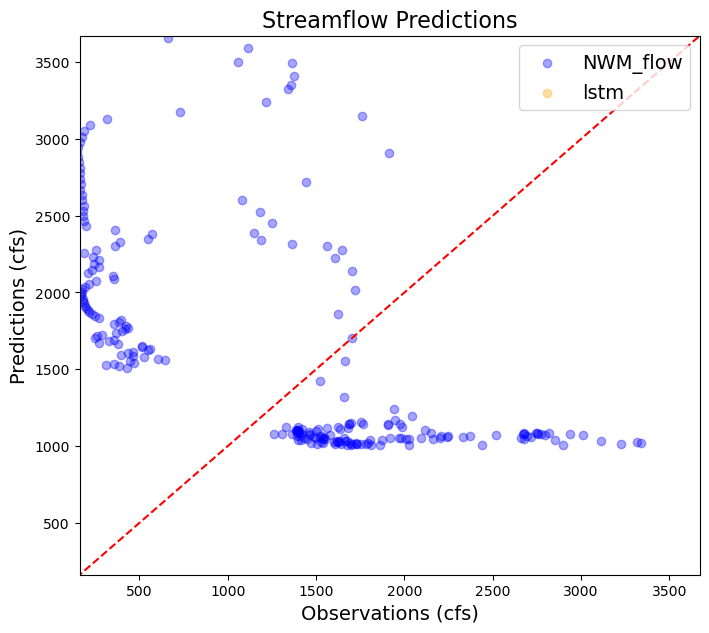

RMSE for  NWM_flow  is  2004.2162424512974  cfs
RMSE for  lstm  is  1404.8005080069756  cfs
Mean Absolute Percentage Error for  NWM_flow  is  368.22 %
Mean Absolute Percentage Error for  lstm  is  90.23 %
Percentage Bias for  NWM_flow  is  -75.45 %
Percentage Bias for  lstm  is  95.64 %
Kling-Glutz Efficiency for  NWM_flow  is  -0.71
Kling-Glutz Efficiency for  lstm  is  -1.29


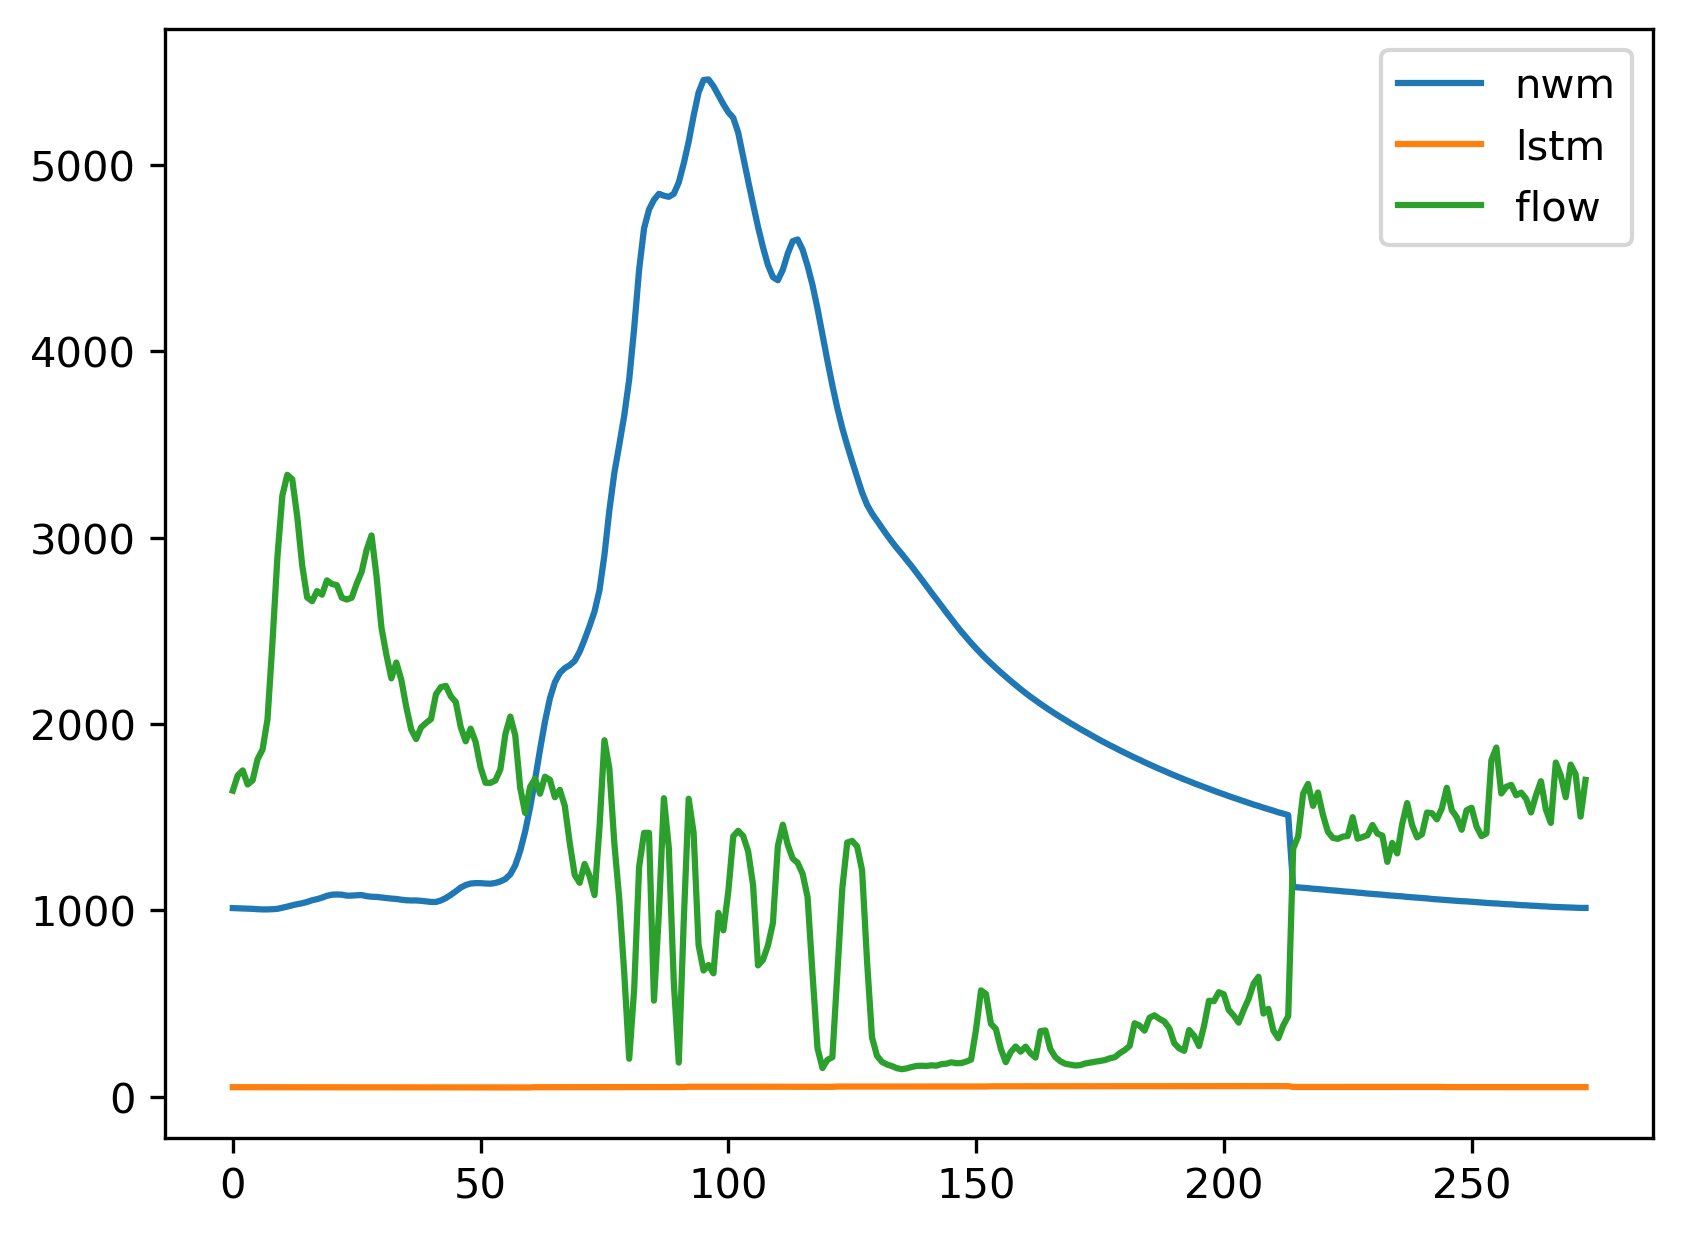

10130500
finish


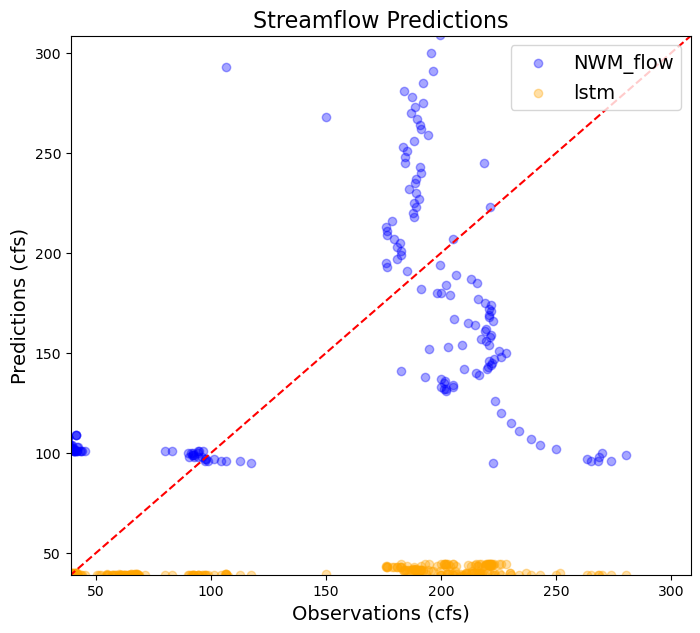

RMSE for  NWM_flow  is  274.01124796954366  cfs
RMSE for  lstm  is  126.6566989194592  cfs
Mean Absolute Percentage Error for  NWM_flow  is  220.1 %
Mean Absolute Percentage Error for  lstm  is  57.86 %
Percentage Bias for  NWM_flow  is  -102.82 %
Percentage Bias for  lstm  is  71.46 %
Kling-Glutz Efficiency for  NWM_flow  is  -1.34
Kling-Glutz Efficiency for  lstm  is  -0.31


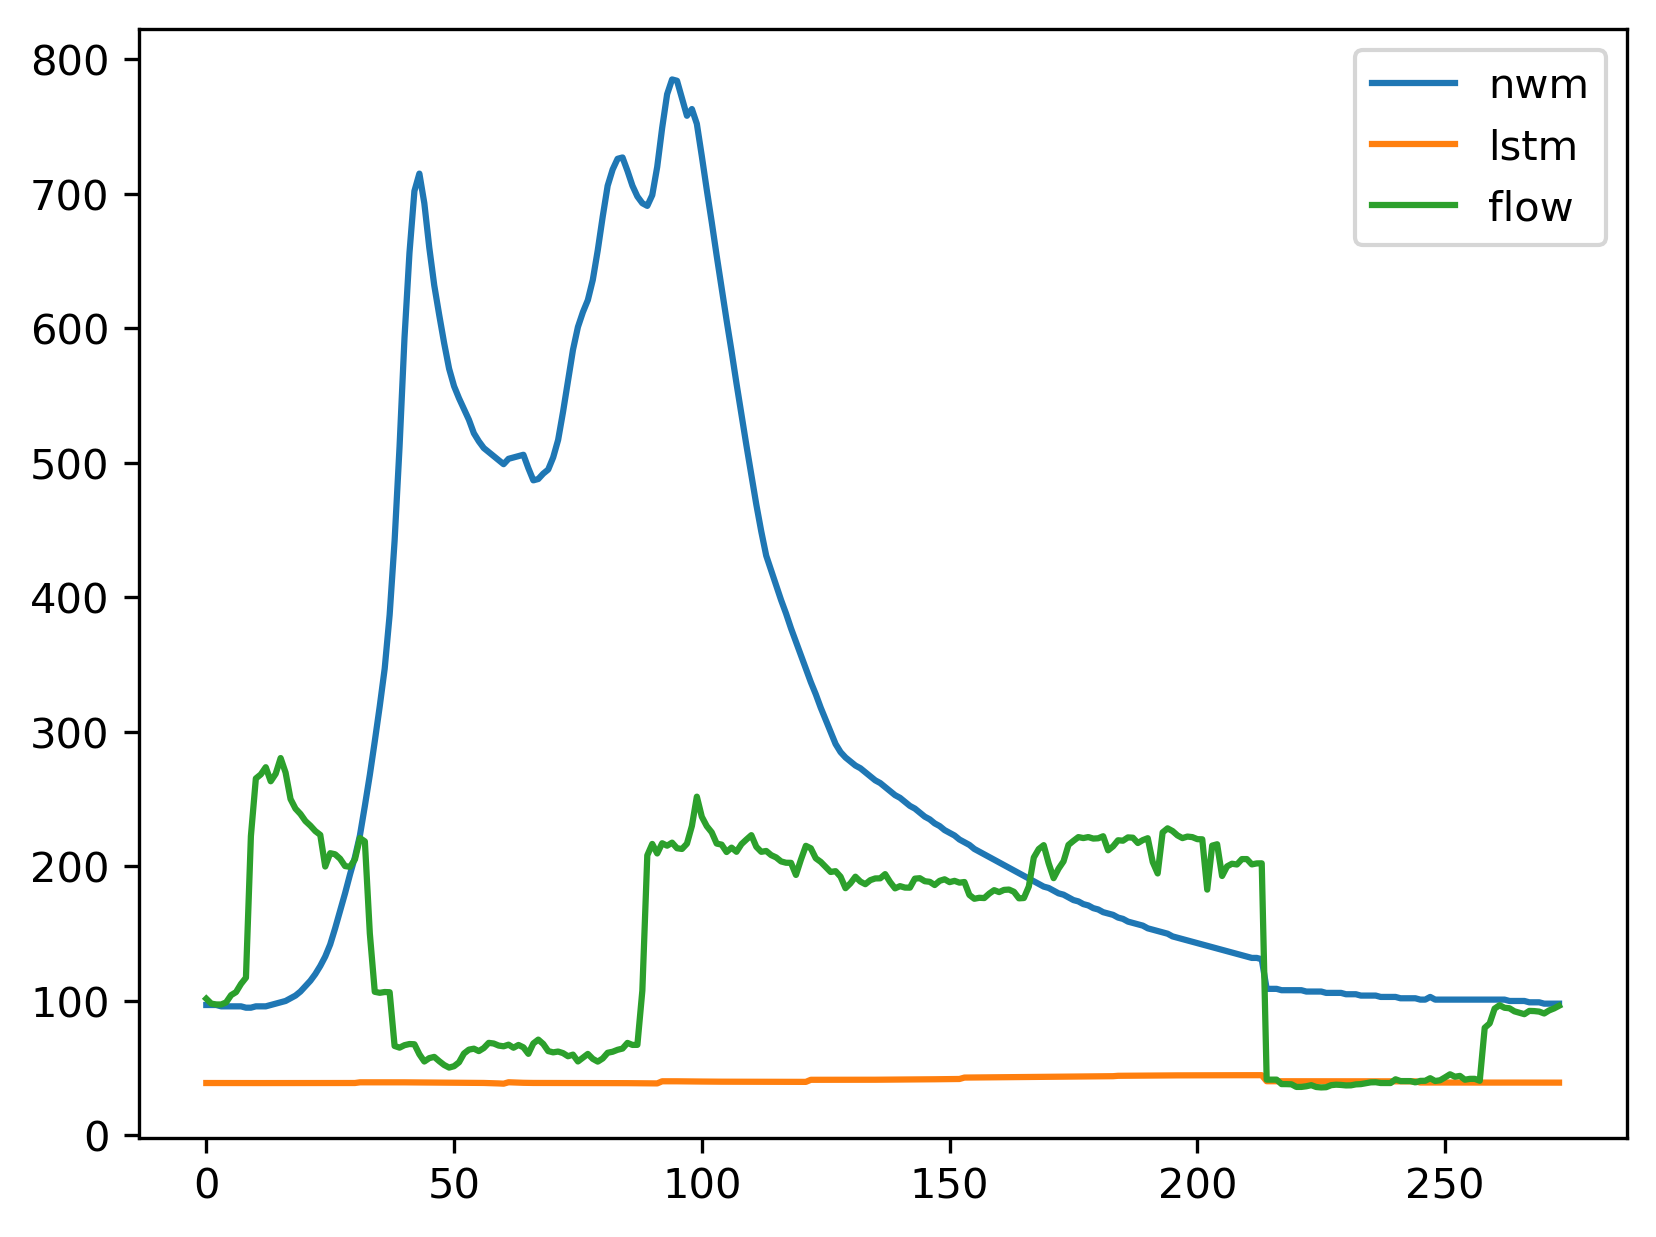

10134500
finish


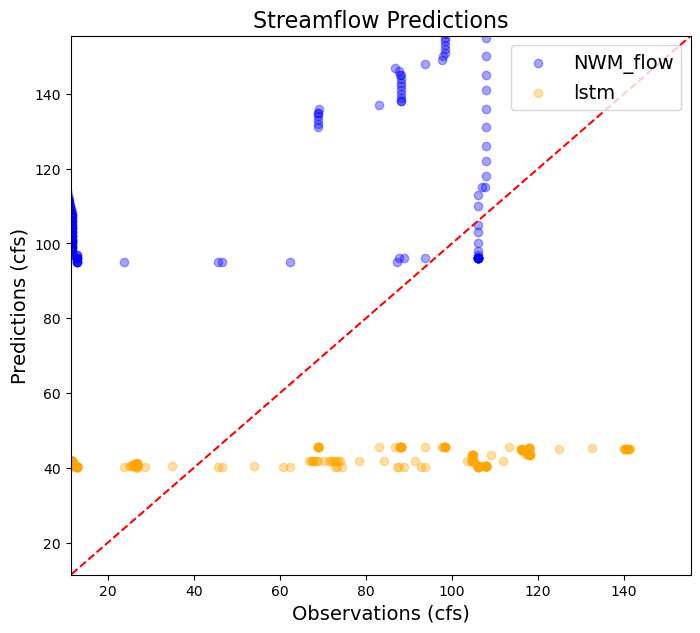

RMSE for  NWM_flow  is  141.56530349786007  cfs
RMSE for  lstm  is  51.247007522291305  cfs
Mean Absolute Percentage Error for  NWM_flow  is  393.93 %
Mean Absolute Percentage Error for  lstm  is  110.17 %
Percentage Bias for  NWM_flow  is  -160.24 %
Percentage Bias for  lstm  is  38.39 %
Kling-Glutz Efficiency for  NWM_flow  is  -1.01
Kling-Glutz Efficiency for  lstm  is  -0.13


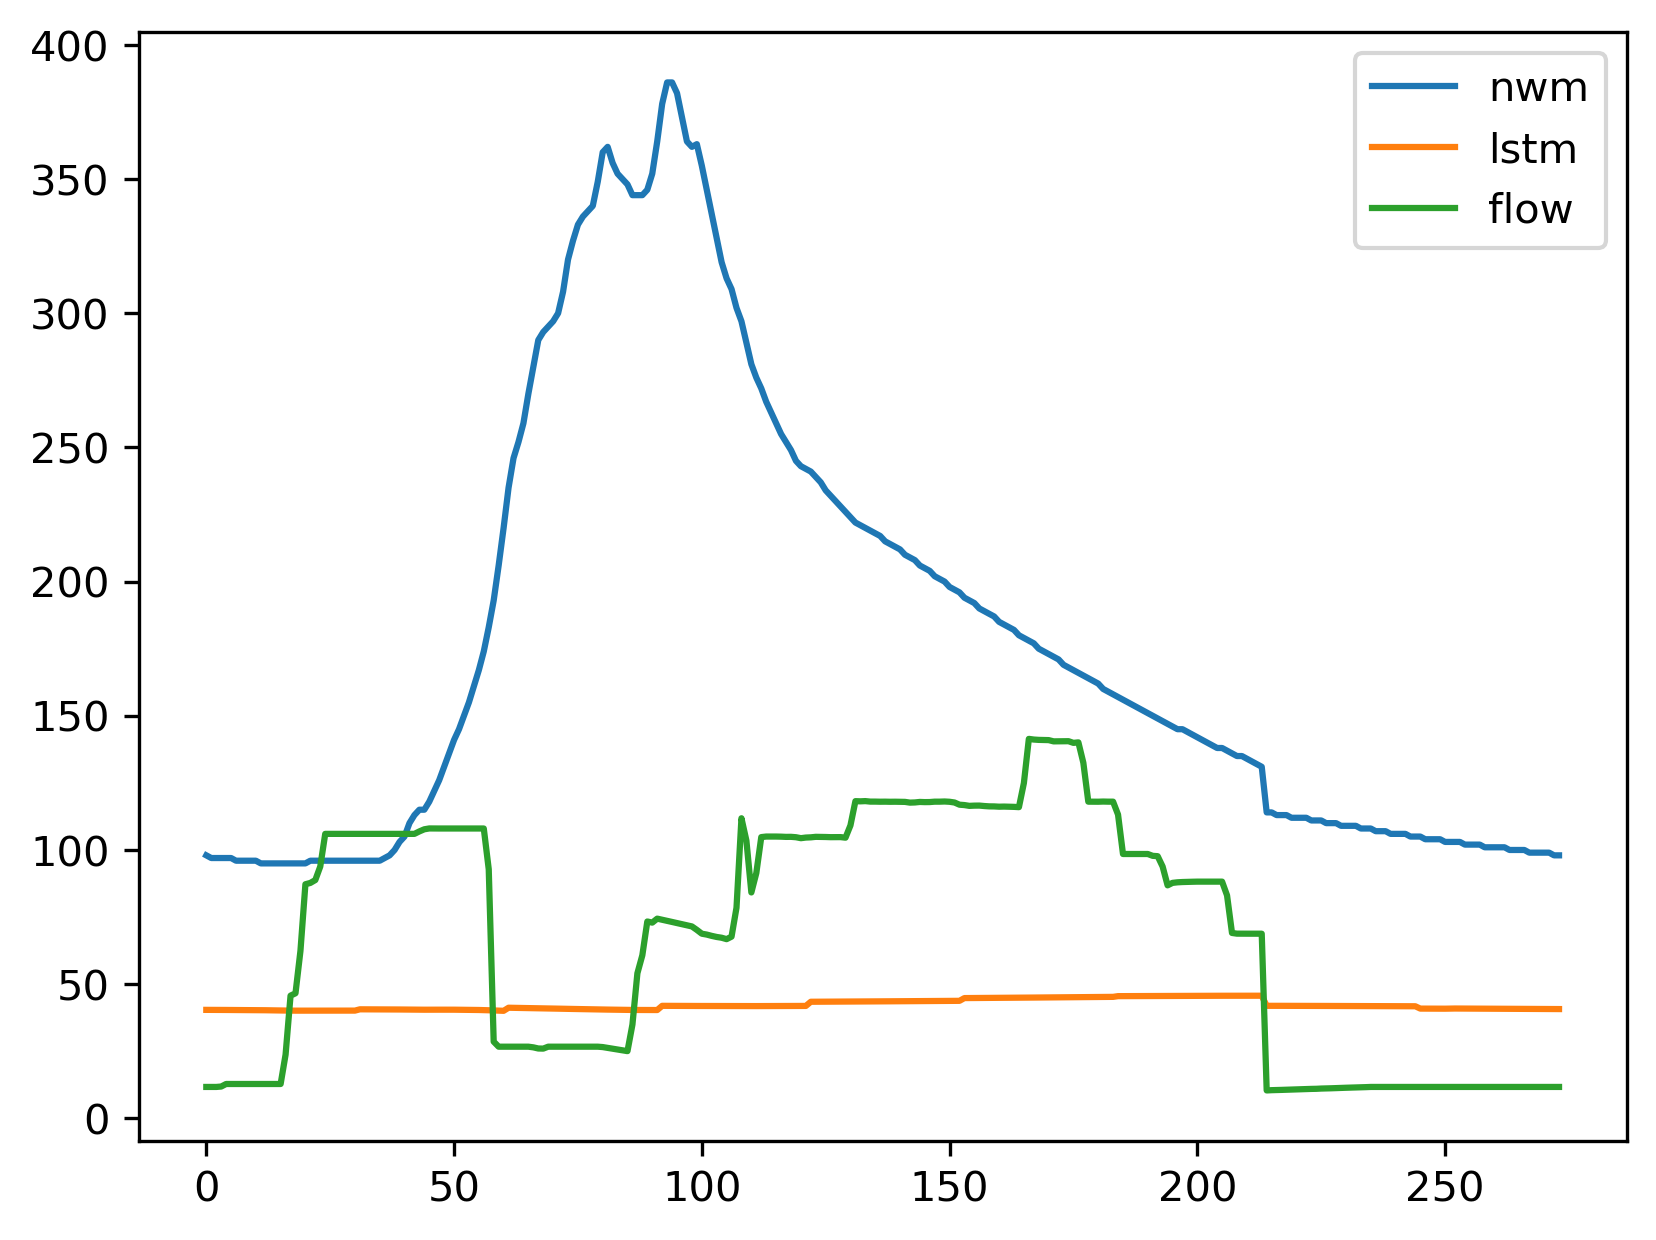

10136500
finish


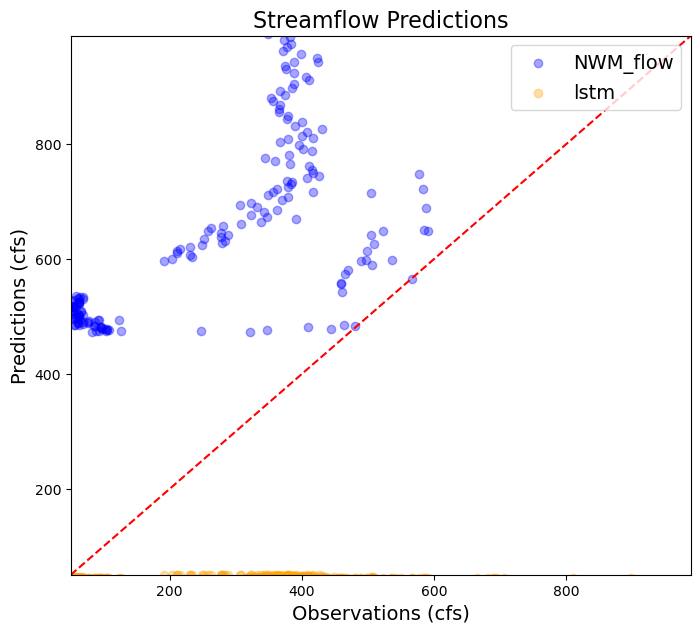

RMSE for  NWM_flow  is  669.7465628383376  cfs
RMSE for  lstm  is  318.57504072768785  cfs
Mean Absolute Percentage Error for  NWM_flow  is  285.84 %
Mean Absolute Percentage Error for  lstm  is  74.08 %
Percentage Bias for  NWM_flow  is  -183.78 %
Percentage Bias for  lstm  is  85.41 %
Kling-Glutz Efficiency for  NWM_flow  is  -1.33
Kling-Glutz Efficiency for  lstm  is  -0.64


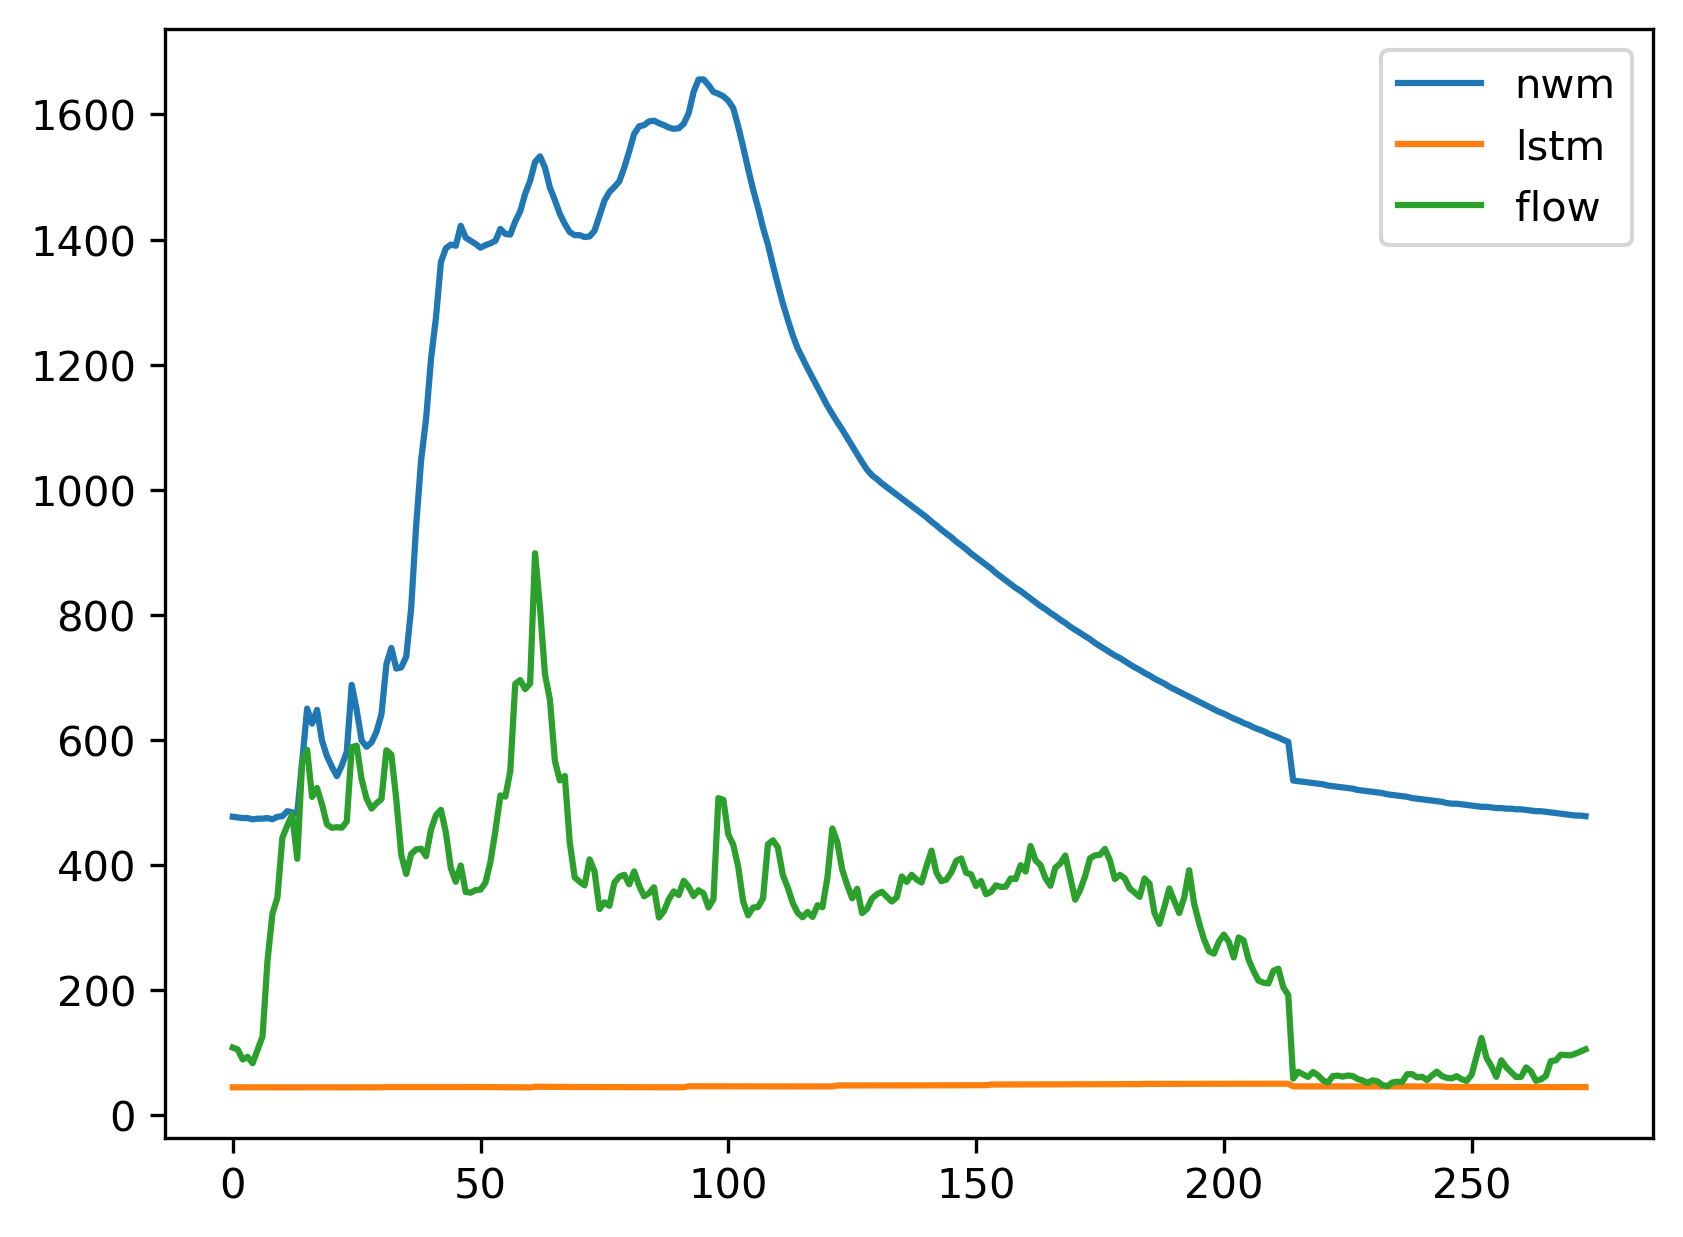

10137500
finish


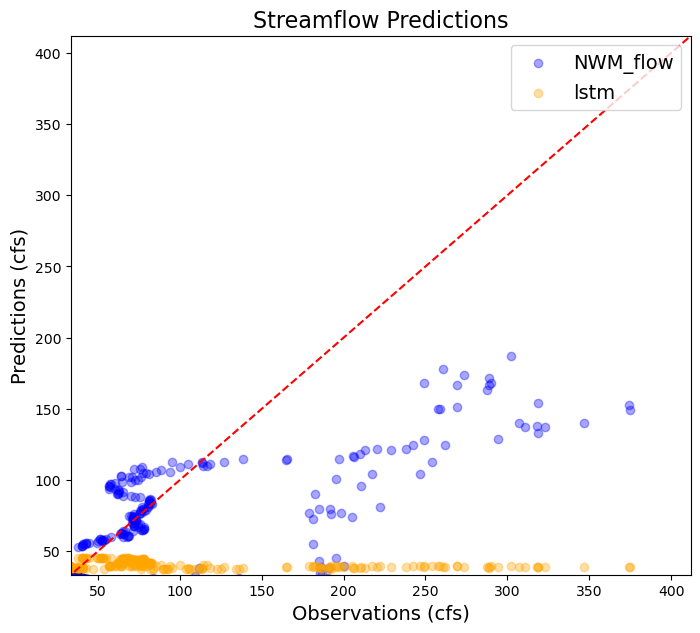

RMSE for  NWM_flow  is  66.07009743205339  cfs
RMSE for  lstm  is  100.86737895595915  cfs
Mean Absolute Percentage Error for  NWM_flow  is  29.53 %
Mean Absolute Percentage Error for  lstm  is  44.32 %
Percentage Bias for  NWM_flow  is  28.12 %
Percentage Bias for  lstm  is  59.68 %
Kling-Glutz Efficiency for  NWM_flow  is  0.33
Kling-Glutz Efficiency for  lstm  is  -0.75


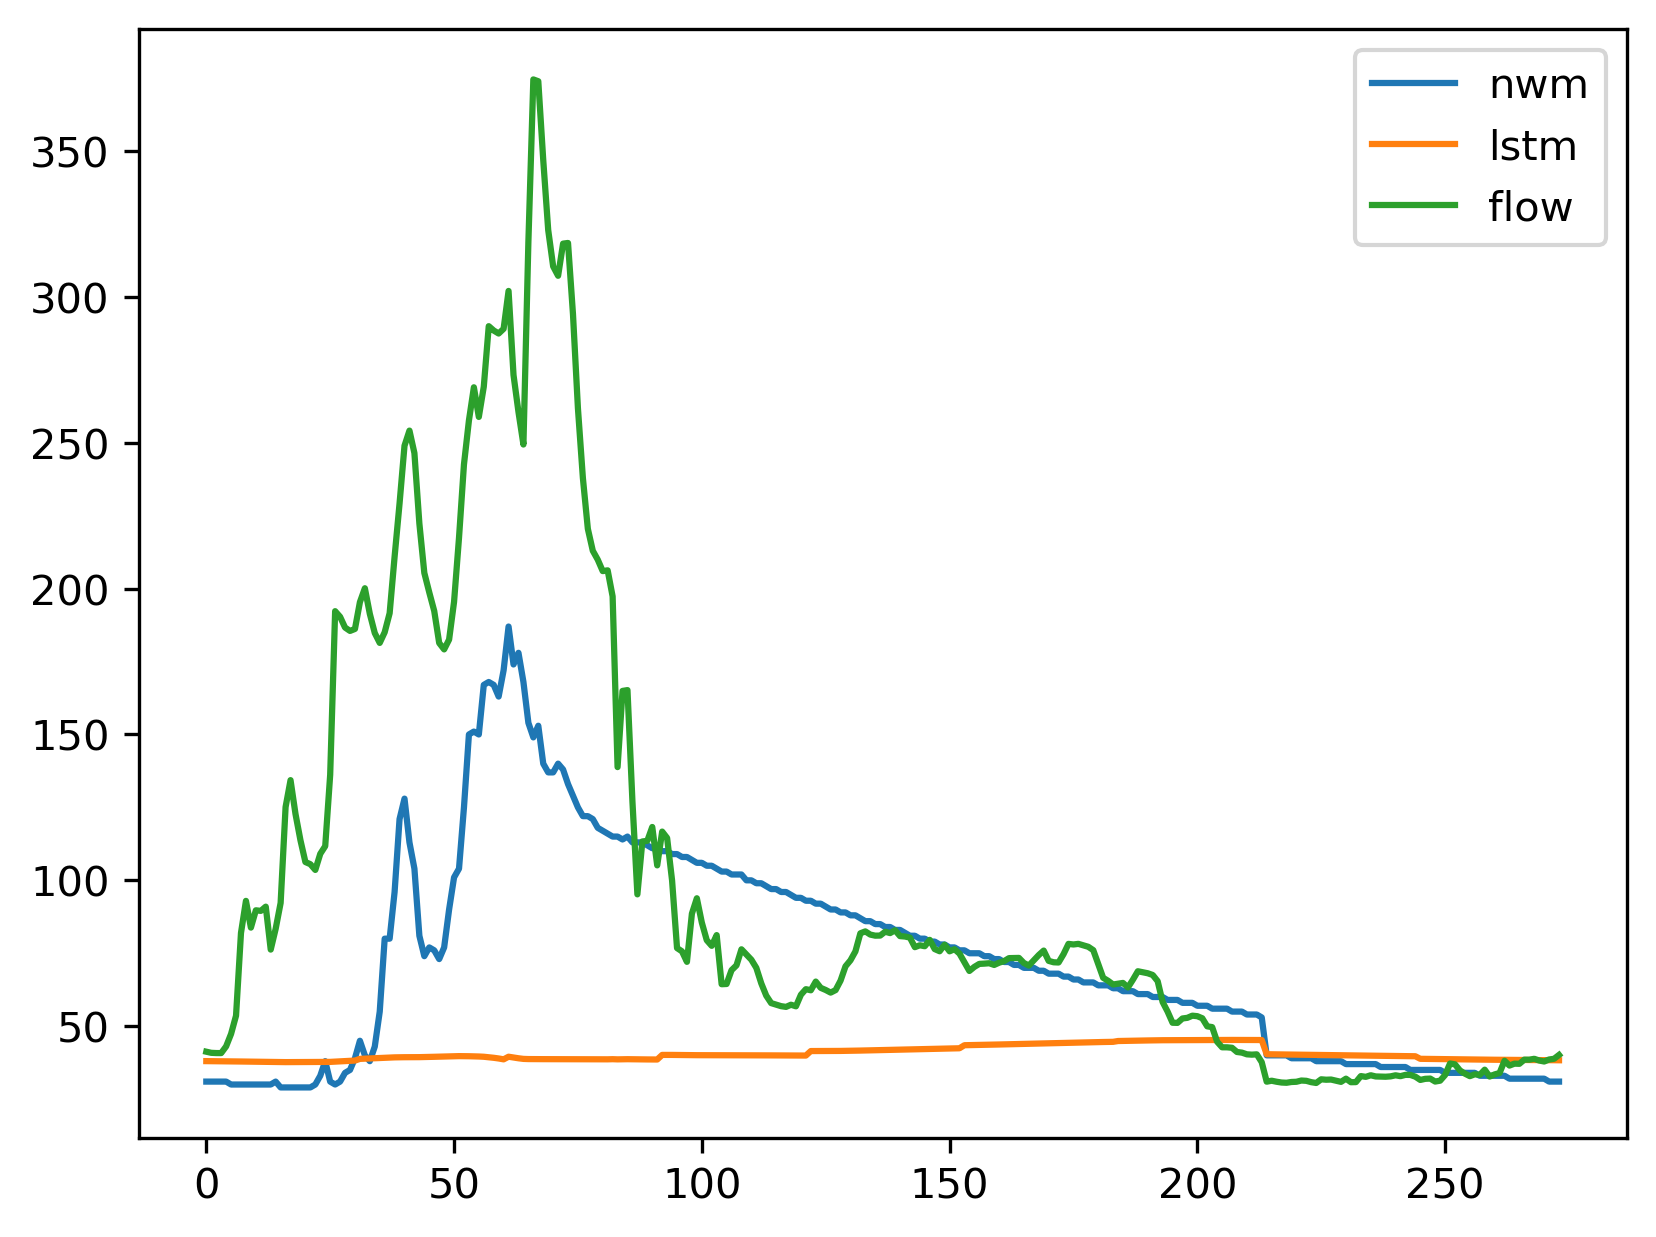

10141000
finish


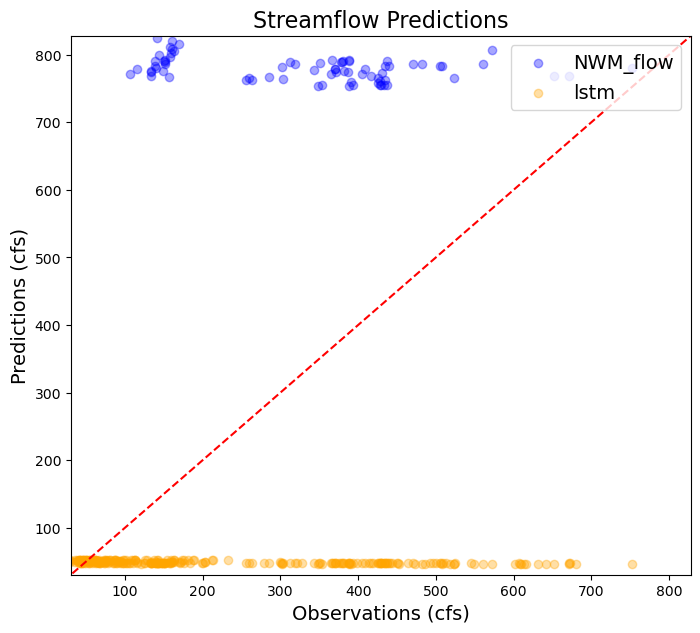

RMSE for  NWM_flow  is  1176.666053882959  cfs
RMSE for  lstm  is  250.83029394353156  cfs
Mean Absolute Percentage Error for  NWM_flow  is  1141.47 %
Mean Absolute Percentage Error for  lstm  is  59.32 %
Percentage Bias for  NWM_flow  is  -471.48 %
Percentage Bias for  lstm  is  77.89 %
Kling-Glutz Efficiency for  NWM_flow  is  -4.13
Kling-Glutz Efficiency for  lstm  is  -1.01


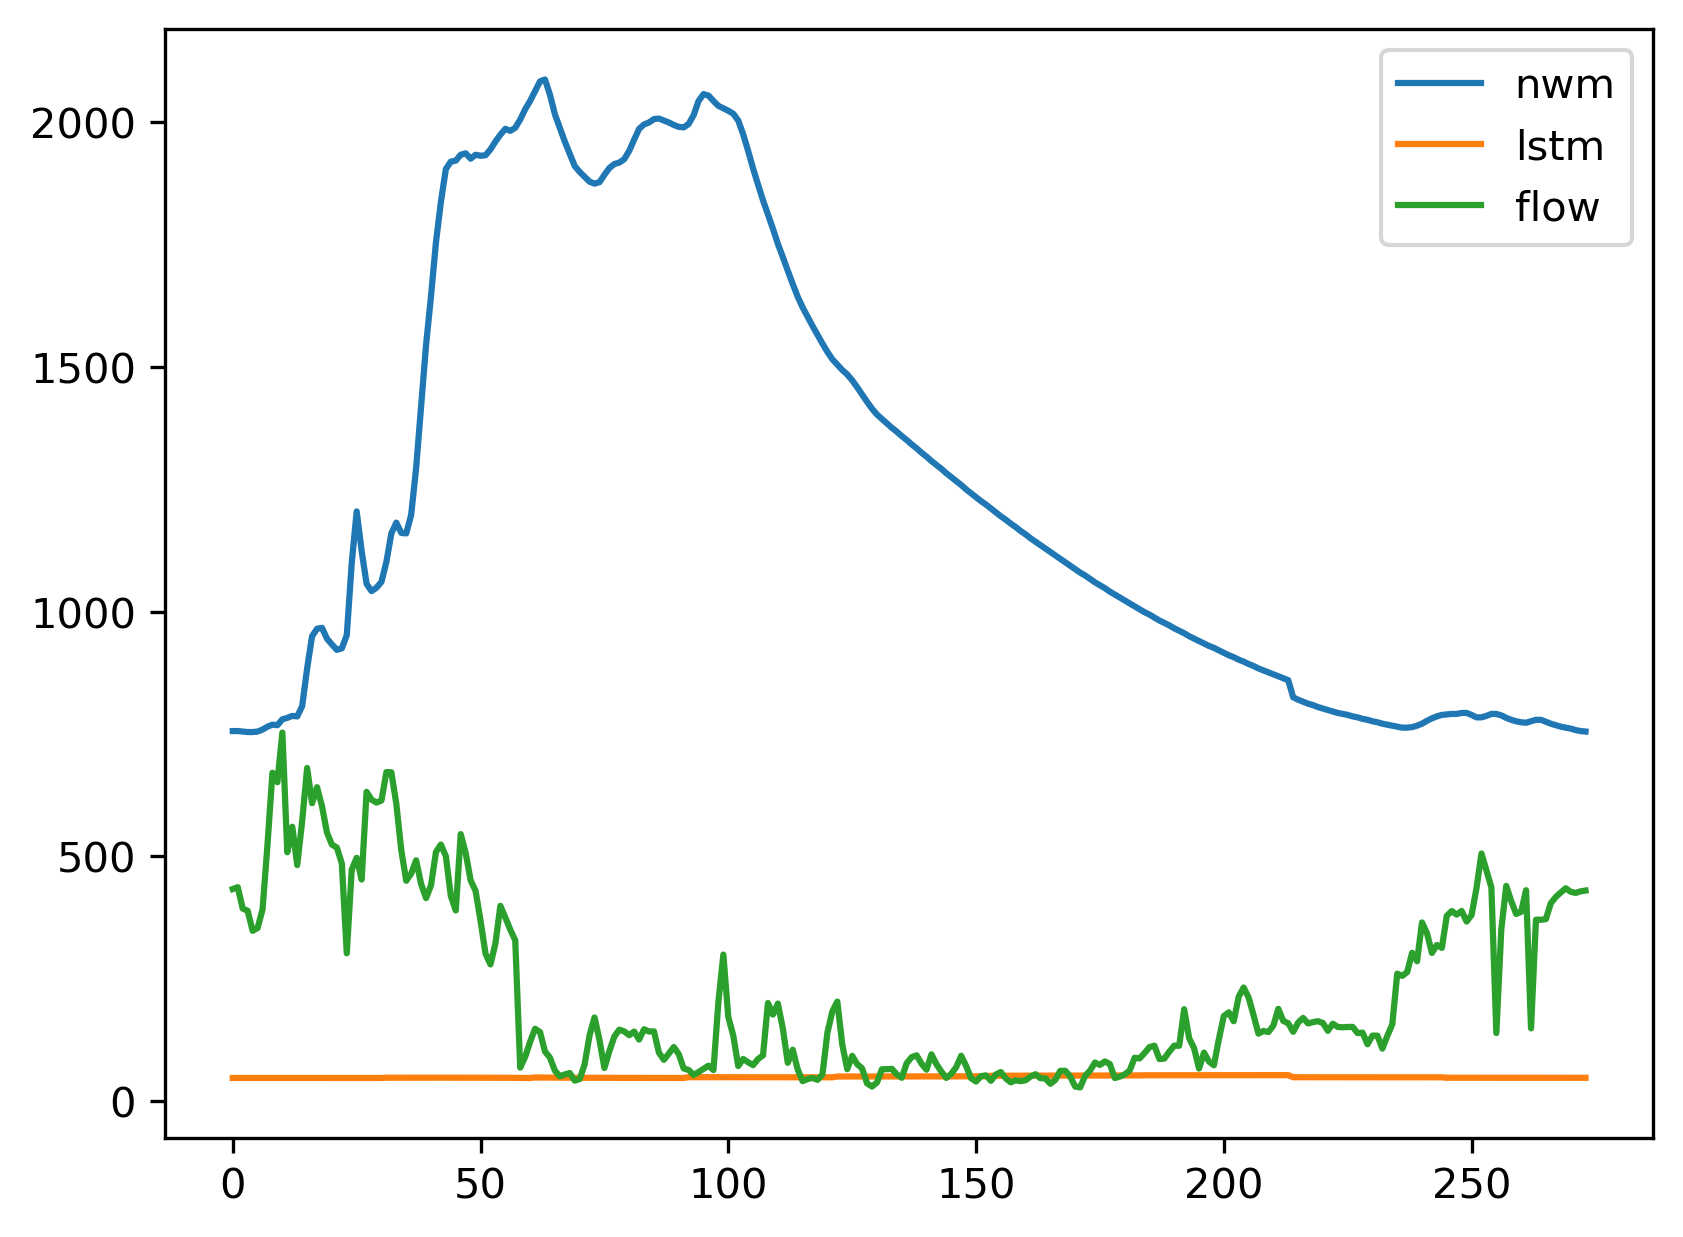

10155000
finish


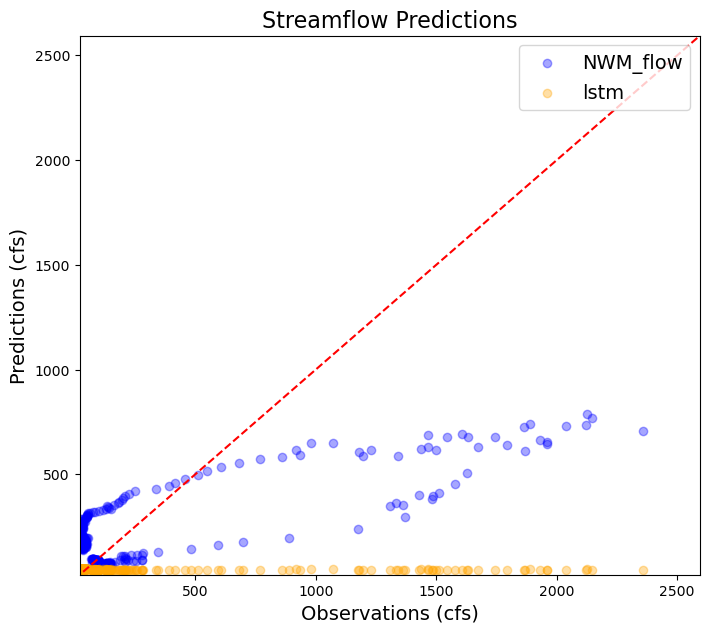

RMSE for  NWM_flow  is  417.2426961886918  cfs
RMSE for  lstm  is  614.5204075648918  cfs
Mean Absolute Percentage Error for  NWM_flow  is  193.64 %
Mean Absolute Percentage Error for  lstm  is  60.12 %
Percentage Bias for  NWM_flow  is  30.12 %
Percentage Bias for  lstm  is  86.46 %
Kling-Glutz Efficiency for  NWM_flow  is  0.26
Kling-Glutz Efficiency for  lstm  is  -0.82


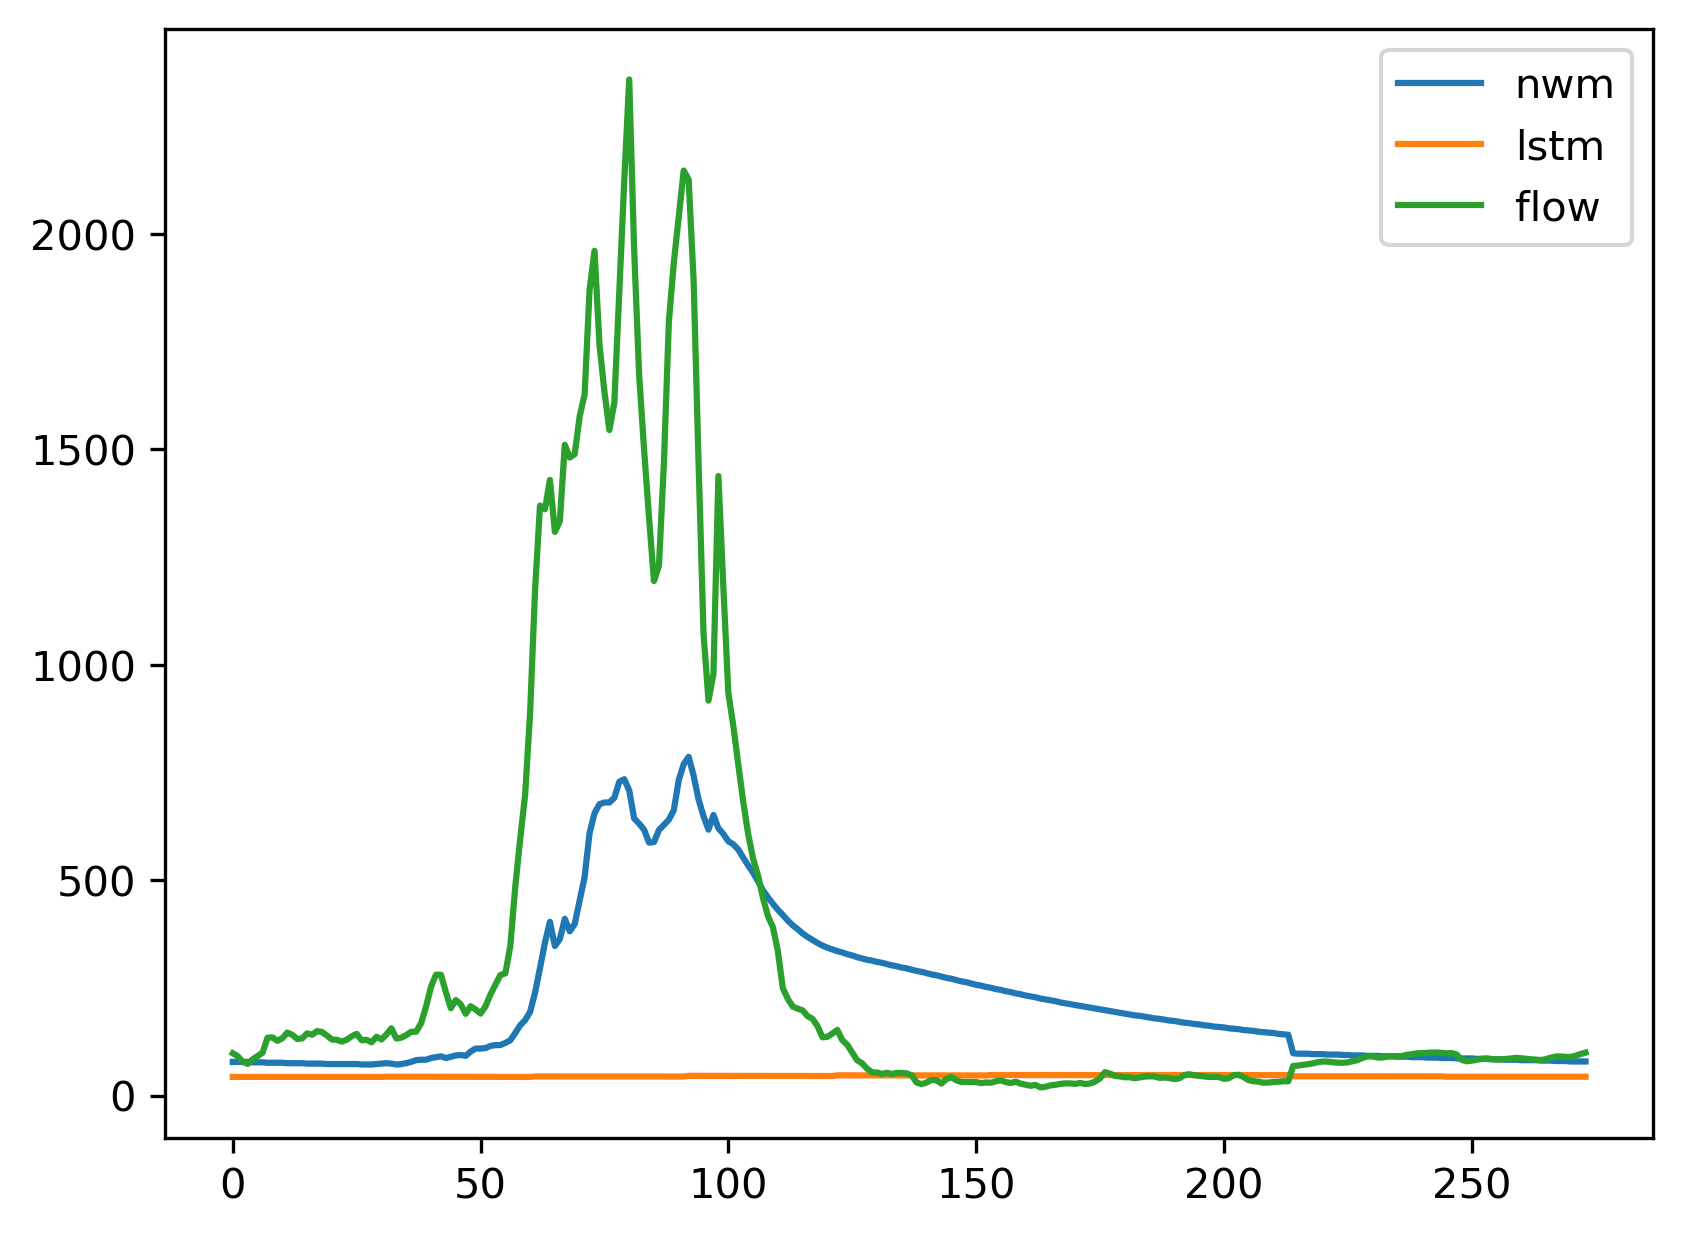

10164500
finish


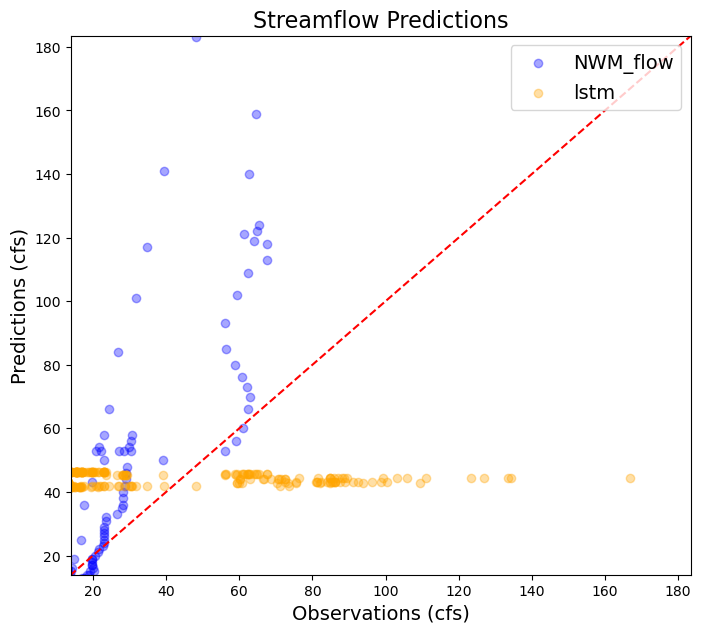

RMSE for  NWM_flow  is  156.89735388632405  cfs
RMSE for  lstm  is  32.19508883921887  cfs
Mean Absolute Percentage Error for  NWM_flow  is  110.94 %
Mean Absolute Percentage Error for  lstm  is  136.94 %
Percentage Bias for  NWM_flow  is  -205.18 %
Percentage Bias for  lstm  is  -21.26 %
Kling-Glutz Efficiency for  NWM_flow  is  -3.78
Kling-Glutz Efficiency for  lstm  is  -0.32


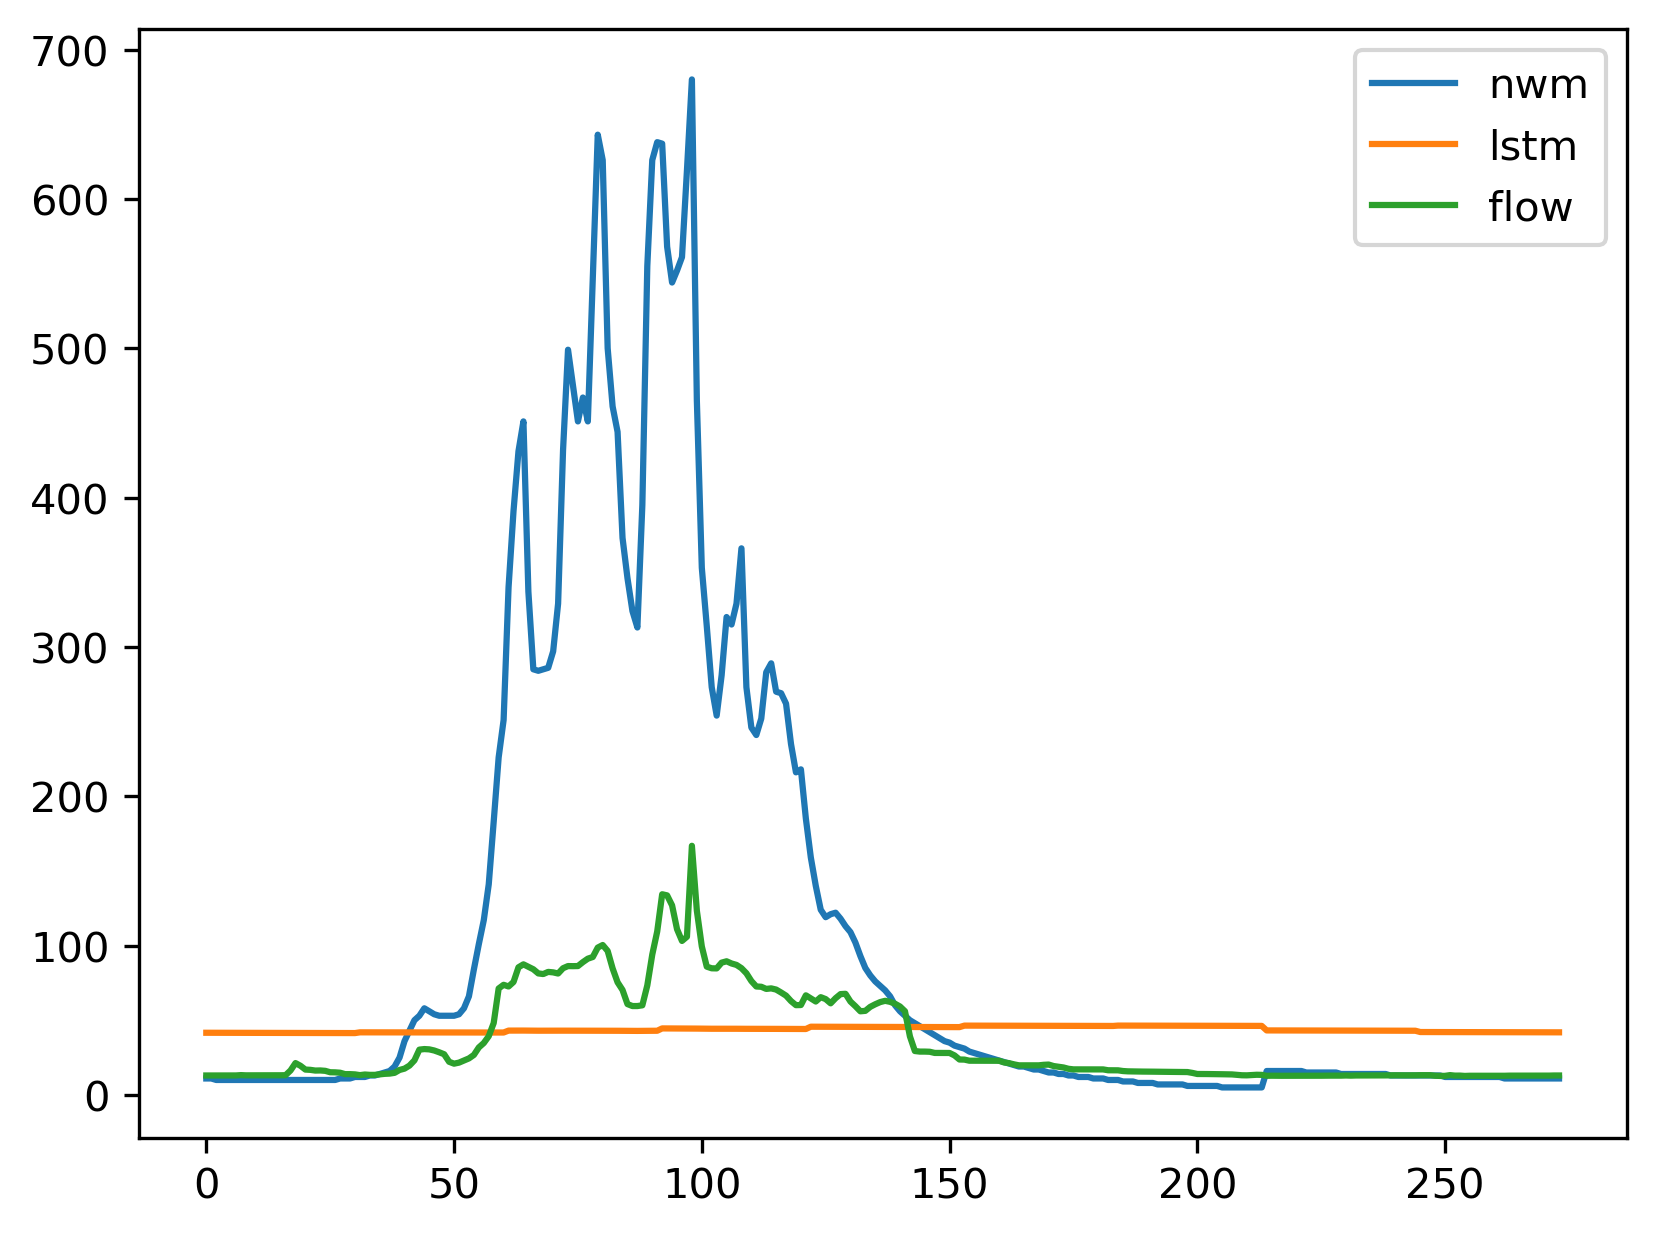

10171000
finish


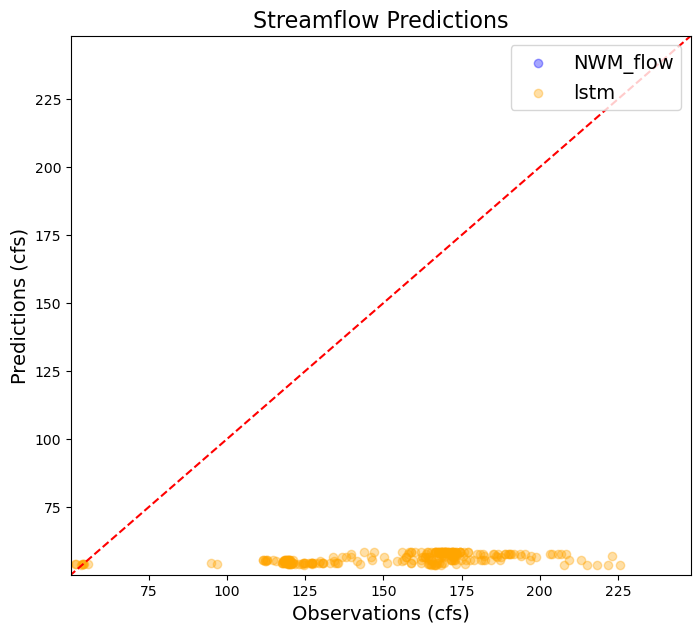

RMSE for  NWM_flow  is  3387.369919215001  cfs
RMSE for  lstm  is  100.48624037758971  cfs
Mean Absolute Percentage Error for  NWM_flow  is  2549.8 %
Mean Absolute Percentage Error for  lstm  is  59.05 %
Percentage Bias for  NWM_flow  is  -2260.76 %
Percentage Bias for  lstm  is  62.36 %
Kling-Glutz Efficiency for  NWM_flow  is  -22.9
Kling-Glutz Efficiency for  lstm  is  -0.22


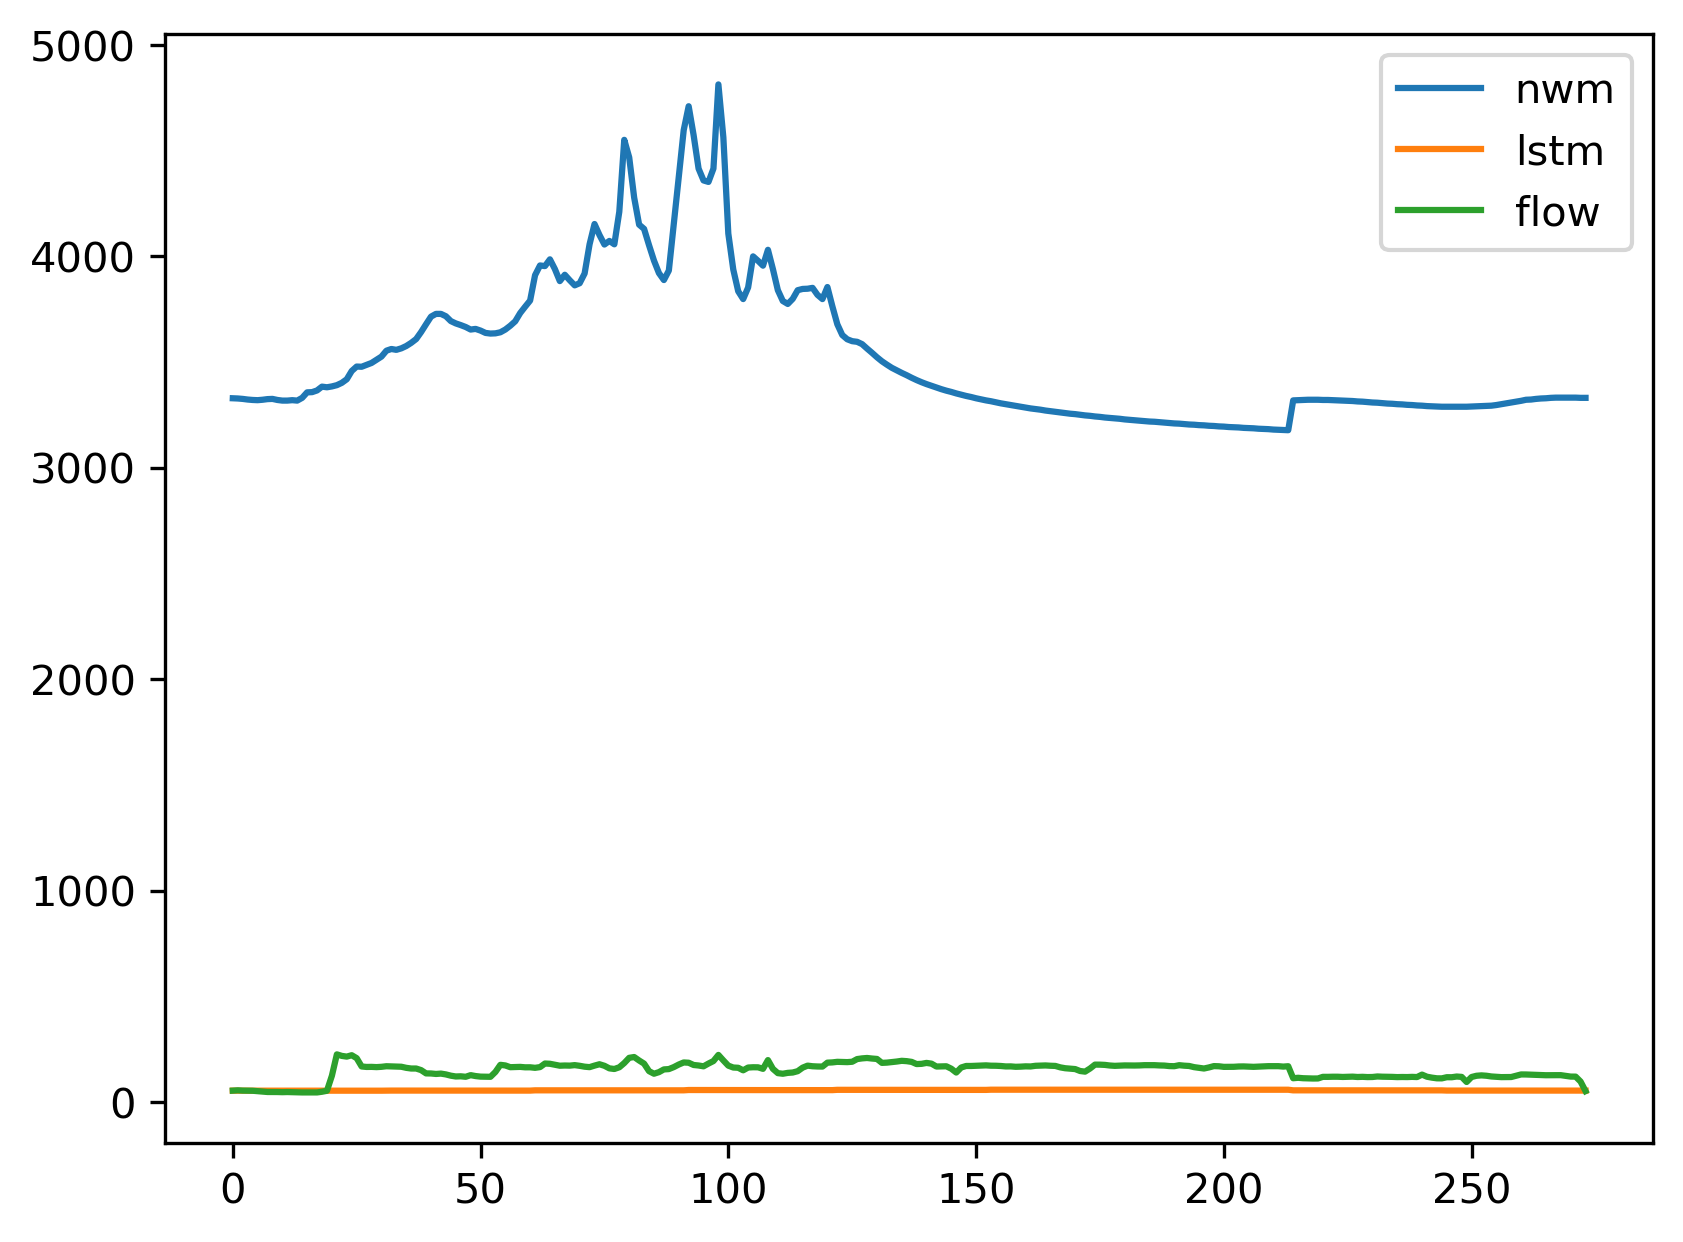

finish


In [41]:
# %%    # Evaluation


for station_number in station_index_list.drop_duplicates():
    print(station_number)
    index = station_index_list == station_number
    device = torch.device('cuda')
    x_train_scaled_test = x_train_scaled_test.to(device)
    model = model.to(device)


    X_test = x_test_temp_1[index]

    X_test_scaled = torch.Tensor(x_test_1_scaled[index]).unsqueeze(2).to(device)
    y_test = y_test_temp_1[index]

    model.eval()
    with torch.no_grad():



        yhat_test= model(X_test_scaled)


    # Invert scaling for actual
    device = torch.device('cpu')

    yhat_test = yhat_test.to(device)


    inv_yhat_test = scaler.inverse_transform(yhat_test.numpy())
    
    inv_yhat_test[inv_yhat_test<0] = 0
    print('finish')
    # %%

    #nwm_lstm = np.concatenate((inv_yhat_train, inv_yhat_test), axis=0)

    nwm_lstm_test = pd.DataFrame(inv_yhat_test, columns=['lstm'])

    Dfs = [nwm_lstm_test.reset_index(drop=True), x_test_temp_1[index].reset_index(drop=True), y_test.reset_index(drop=True)]



    # merge
    Eval_DF_mine = pd.concat(Dfs, axis=1)
    prediction_columns = [ 'NWM_flow', 'lstm']

    #plot the predictions
    Model_Evaluation_Plots(Eval_DF_mine, prediction_columns)

    #Get RMSE from the model
    RMSE(Eval_DF_mine, prediction_columns)

    #Get Mean Absolute Percentage Error from the model
    MAPE(Eval_DF_mine, prediction_columns)

    #Get Percent Bias from the model
    PBias(Eval_DF_mine, prediction_columns)

    #Get Kling-Gutz Efficiency from the model
    KGE(Eval_DF_mine, prediction_columns)
    
    fig, axs = plt.subplots(dpi=300)


    axs.plot(range(len(Eval_DF_mine)), Eval_DF_mine['NWM_flow'], label='nwm')

    axs.plot(range(len(Eval_DF_mine)), Eval_DF_mine['lstm'], label='lstm')

    axs.plot(range(len(Eval_DF_mine)), Eval_DF_mine['flow_cfs'], label='flow')

    plt.legend()

    plt.show()
    
print('finish')